<a href="https://colab.research.google.com/github/JuanC-Fandino/RedClasificacionResiduos/blob/master/RedClasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Obtención del Dataset

In [2]:
!git clone https://github.com/JuanC-Fandino/RedClasificacionResiduos.git

fatal: destination path 'RedClasificacionResiduos' already exists and is not an empty directory.


# Creación de los sets de entrenamiento y validación

In [3]:
DIR = "/content/RedClasificacionResiduos/dataset"
alto_img = 256
ancho_img = 256
batch_size = 128
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.2, subset="training", batch_size=batch_size, smart_resize=True, image_size=(alto_img, ancho_img), seed=25)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.2, subset="validation", batch_size=batch_size, smart_resize=True, image_size=(alto_img, ancho_img), seed=25)

clases = train_dataset.class_names
total_clases = len(train_dataset.class_names)
print(clases)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
['Basura', 'Carton', 'Metal', 'Papel', 'Plastico', 'Vidrio']


# Optimización del flujo de datos

La API tf.data proporciona un mecanismo de canalización de software a través de la transformación tf.data.Dataset.prefetch, que se puede usar para desacoplar el momento en que se producen los datos del momento en que se consumen. En particular, la transformación utiliza un subproceso en segundo plano y un búfer interno para obtener elementos del conjunto de datos de entrada antes de que se soliciten. El número de elementos para precargar debe ser igual (o posiblemente mayor que) el número de lotes consumidos por un solo paso de entrenamiento. Puede ajustar manualmente este valor o establecerlo en tf.data.experimental.AUTOTUNE, lo que hará que el tiempo de ejecución de tf.data ajuste el valor de forma dinámica en el tiempo de ejecución.

tf.data crea un modelo de rendimiento de la canalización de entrada y ejecuta un algoritmo de optimización para encontrar una buena asignación de su presupuesto de CPU en todos los parámetros especificados como AUTOTUNE. Mientras se ejecuta la canalización de entrada, tf.data realiza un seguimiento del tiempo empleado en cada operación, de modo que estos tiempos puedan incorporarse al algoritmo de optimización.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Entrenamiento del modelo

In [5]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(alto_img,
                                  ancho_img,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)



model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(total_clases)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs=10
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

NameError: ignored

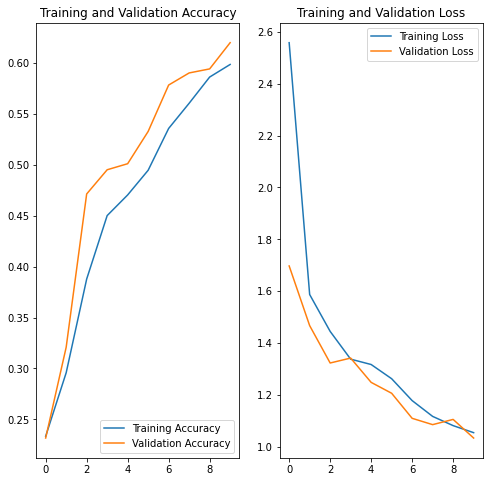

In [6]:
epochs_range = range(epochs)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
